# Model Regression for Loss Given Default 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

%config IPCompleter.greedy=True

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings("ignore")

In [2]:

df = pd.read_pickle('../../02_Data/03_Work/df_board_lgd.pickle')


In [3]:
x = df.drop(columns='target_lgd')
y = df.target_lgd

## MODEL

In [5]:

train_x,val_x,train_y,val_y = train_test_split(x,y,test_size=0.3)


In [6]:
pipe = Pipeline([('algorythm',Ridge())])

grid = [      
        {'algorythm': [Ridge()],
         'algorythm__alpha': list(np.arange(0.1,1.1,0.1))},
        
        {'algorythm': [Lasso()],
         'algorythm__alpha': list(np.arange(0.1,1.1,0.1))},
    
        {'algorythm': [HistGradientBoostingRegressor(min_samples_leaf = 100, scoring = 'neg_mean_absolute_percentage_error')],
         'algorythm__learning_rate': [0.01,0.025,0.05,0.1],
         'algorythm__max_iter': [50,100,200],
         'algorythm__max_depth': [5,10,20],
         'algorythm__l2_regularization': [0,0.25,0.5,0.75,1]}
       ]

#### Optimize hyperparameters

In [8]:
grid_search = GridSearchCV(estimator= pipe, 
                           param_grid = grid, 
                           cv = 3, 
                           scoring = 'neg_mean_absolute_error',
                           verbose = 0,
                           n_jobs = -1)

model = grid_search.fit(train_x,train_y)

In [9]:
# since it's very polarized, the model makes a lot of error
# the model makes a regression towards the mean
# this makes the model be "good" overall, but fails a lot when looking at specific cases



In [10]:
output = pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score').reset_index(drop=True).head(10)
output

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorythm,param_algorythm__alpha,param_algorythm__l2_regularization,param_algorythm__learning_rate,param_algorythm__max_depth,param_algorythm__max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,21.27,0.27,0.53,0.02,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0,0.10,10,200,{'algorythm': HistGradientBoostingRegressor(mi...,-0.37,-0.37,-0.38,-0.37,0.00,1
1,14.74,1.10,0.24,0.01,HistGradientBoostingRegressor(min_samples_leaf...,NaN,1,0.10,20,200,{'algorythm': HistGradientBoostingRegressor(mi...,-0.37,-0.38,-0.38,-0.37,0.00,2
2,19.67,2.21,0.51,0.04,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.75,0.10,20,200,{'algorythm': HistGradientBoostingRegressor(mi...,-0.37,-0.38,-0.37,-0.38,0.00,3
3,21.83,0.14,0.56,0.02,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0,0.10,20,200,{'algorythm': HistGradientBoostingRegressor(mi...,-0.38,-0.38,-0.37,-0.38,0.00,4
4,20.55,0.26,0.53,0.02,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.75,0.10,10,200,{'algorythm': HistGradientBoostingRegressor(mi...,-0.37,-0.38,-0.37,-0.38,0.00,5
5,19.26,2.78,0.53,0.01,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.25,0.10,20,200,{'algorythm': HistGradientBoostingRegressor(mi...,-0.38,-0.38,-0.37,-0.38,0.00,6
6,22.00,0.55,0.58,0.03,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.50,0.10,10,200,{'algorythm': HistGradientBoostingRegressor(mi...,-0.38,-0.38,-0.38,-0.38,0.00,7
7,22.88,1.50,0.56,0.04,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.50,0.10,20,200,{'algorythm': HistGradientBoostingRegressor(mi...,-0.38,-0.38,-0.38,-0.38,0.00,8
8,17.22,0.48,0.27,0.01,HistGradientBoostingRegressor(min_samples_leaf...,NaN,1,0.10,10,200,{'algorythm': HistGradientBoostingRegressor(mi...,-0.38,-0.38,-0.38,-0.38,0.00,9
9,21.45,0.24,0.52,0.00,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.25,0.10,10,200,{'algorythm': HistGradientBoostingRegressor(mi...,-0.38,-0.38,-0.38,-0.38,0.00,10


In [11]:
model_lgd = HistGradientBoostingRegressor(learning_rate = 0.1,
                                          max_iter = 200,
                                          max_depth = 20,
                                          min_samples_leaf = 100,
                                          scoring = 'neg_mean_absolute_percentage_error',
                                          l2_regularization = 0.25)
model_lgd.fit(train_x,train_y)

HistGradientBoostingRegressor(l2_regularization=0.25, max_depth=20,
                              max_iter=200, min_samples_leaf=100,
                              scoring='neg_mean_absolute_percentage_error')

### Evaluate

In [12]:
pred = model_lgd.predict(val_x)

pred = np.where(pred < 0, 0, pred)
pred = np.where(pred > 1, 1, pred)

In [13]:
mean_absolute_error(val_y, pred)

0.3714273097245213

### Report

In [14]:
check_validation = pd.DataFrame({'lgd_real':val_y, 'lgd_pred':pred})
check_validation

,lgd_real,lgd_pred
client_id,,
139298063,1.00,0.82
84467306,1.00,0.39
104240916,1.00,0.74
70885317,0.00,0.37
44915767,0.49,0.18
...,...,...
142828974,1.00,0.79
115385827,1.00,0.53
120583000,1.00,0.77


In [15]:
check_validation.corr()

,lgd_real,lgd_pred
lgd_real,1.00,0.53
lgd_pred,0.53,1.00


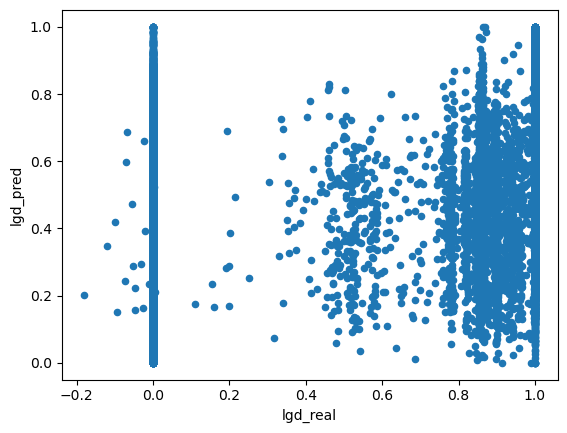

In [16]:
check_validation.plot.scatter(x='lgd_real',y='lgd_pred');

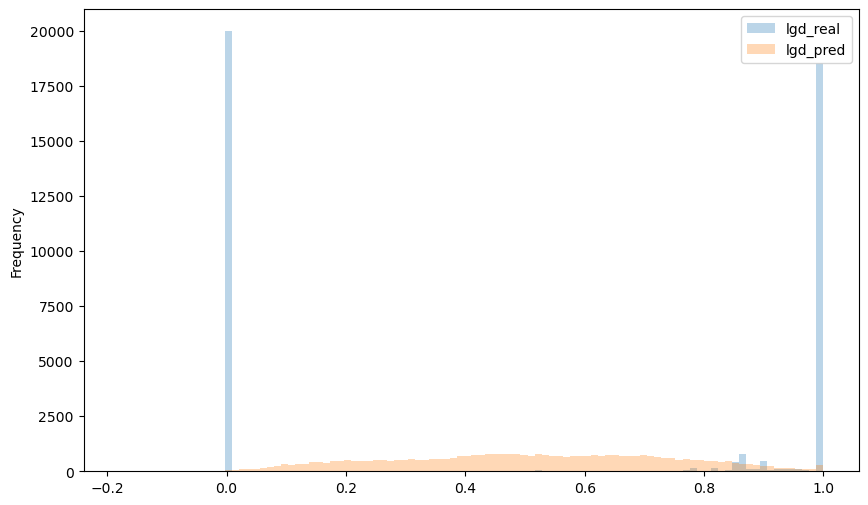

In [17]:
check_validation.plot.hist(bins = 100,figsize = (10,6), alpha = 0.3);